# SSH Hijacking-T1563.001 TH Notebook

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
import json
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import pandas as pd
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

spark = SparkSession.builder \
    .appName("ssh_hijack_blog") \
    .master("spark://helk-spark-master:7077") \
    .config("spark.driver.memory","5g")\
    .config("spark.executor.memory","5g") \
    .enableHiveSupport() \
    .getOrCreate()
spark.conf.set("spark.sql.caseSensitive", "true")  


spark.conf.set("spark.sql.caseSensitive", "true")
#spark.conf.set("spark.sql.catalogImplementation","hive") 

spark


es_reader = (spark.read.format("org.elasticsearch.spark.sql")
    .option("inferSchema", "true")
    .option("es.nodes","helk-elasticsearch:9200")
    .option("es.read.field.include","agent.hostname,auditd.data.lport,auditd.data.laddr,auditd.data.rport,src_ip_addr,auditd.data.direction,tags,process.ppid,process.pid,process.title,event.category,auditd.message_type,auditd.summary.how,user.name,user.effective.name,network.direction,process.args,process.executable,file.path,@timestamp")
    .option("es.read.field.as.array.include","agent.hostname,auditd.data.lport,auditd.data.laddr,auditd.data.rport,src_ip_addr,auditd.data.direction,tags,process.ppid,process.pid,process.title,event.category,auditd.message_type,auditd.summary.how,user.name,user.effective.name,network.direction,process.args,process.executable,file.path,@timestamp")
    .option("es.net.http.auth.user","elastic"))



audit_df = es_reader.load("logs-linux-2020.10.06")

## Try to find  ssh sockets - on target or hop 


this hypothesis will try to find all ssh socket creations   
using auditd rule :  
 -a always,exit -F arch=b64 -S socket -F a0=2 -k T1011_Exfiltration_Over_Other_Network_Medium_4  
 you can read this blog to understand what the rule means -   
https://www.linkedin.com/pulse/using-auditd-monitor-network-connections-alex-maestretti   

-- it goes over 6 hour windows
everything found suspicious will be flaged with "trigger4"  
the socket is opened on the TARGET   


In [2]:
#get all ipv4 socket opened
read_audit_exfil = audit_df.select(F.col("process.pid").alias("process_pid"),F.col("agent.hostname").alias("hostname"),\
                                   F.col("process.title").alias("process_title"),F.col("process.executable").alias("process_exec"),\
                                   F.col("user.name").alias("user_name"),F.col("@timestamp").alias("time")).filter(F.array_contains("tags","T1011_Exfiltration_Over_Other_Network_Medium_4"))

read_audit_exfil = read_audit_exfil.withColumn("process_pid", read_audit_exfil["process_pid"]
                                                .getItem(0)).withColumn("hostname", read_audit_exfil["hostname"]
                                                .getItem(0)).withColumn("process_exec", read_audit_exfil["process_exec"]
                                                .getItem(0)).withColumn("process_title", read_audit_exfil["process_title"] 
                                                ).withColumn("user_name", read_audit_exfil["user_name"]                                                                        
                                                .getItem(0)).withColumn("time", read_audit_exfil["time"].getItem(0))
    
#search any ssh process  that run not only the default ssh client (in bin dir)
read_audit_exfil = read_audit_exfil.filter(F.col("process_exec").contains("ssh"))

#search socket in time window of 6 hours
read_audit_exfil = read_audit_exfil.groupby(F.col("hostname"),F.col("process_pid"),F.window("time", "6 hours")).agg(F.min("time").alias('socket_min_time'),F.max("time").alias('socket_max_time'))

#flag to point out that the socket is related to this hypotesis
read_audit_exfil = read_audit_exfil.withColumn("trigger4", F.lit(1))

In [3]:
read_audit_exfil_pd = read_audit_exfil.toPandas()
read_audit_exfil_pd.head()

,hostname,process_pid,window,socket_min_time,socket_max_time,trigger4
0,centos8-more-rules,1832,"(2020-10-06 06:00:00, 2020-10-06 12:00:00)",2020-10-06 07:22:22.245,2020-10-06 07:22:22.245,1
1,centos8-more-rules,2047,"(2020-10-06 06:00:00, 2020-10-06 12:00:00)",2020-10-06 07:39:35.204,2020-10-06 07:39:35.204,1
2,centos7-more-rules,19662,"(2020-10-06 06:00:00, 2020-10-06 12:00:00)",2020-10-06 07:30:35.987,2020-10-06 07:30:35.987,1
3,centos7-more-rules,21506,"(2020-10-06 12:00:00, 2020-10-06 18:00:00)",2020-10-06 13:22:11.066,2020-10-06 13:22:11.066,1
4,centos7-more-rules,18790,"(2020-10-06 00:00:00, 2020-10-06 06:00:00)",2020-10-06 05:31:08.261,2020-10-06 05:31:08.261,1


##  ssh_config was changed - on hop


this hypothesis will look for ssh_config file changes   
using auditd rule :  
-w /etc/ssh/sshd_config -p aw -k ssh_conf_modification  
it will search ssh configuration changes over 12 hour windwos  

the ssh configuration change is on the HOP  


In [4]:
#select only specific fields from the whole data
audit_ssh_conf = audit_df.select(F.col("tags").alias("tags"),F.col("process.pid").alias("process_pid"),F.col("agent.hostname").alias("hostname"),\
                                 F.col("process.executable").alias("process_exec"),F.col("user.effective.name").alias("user_effective_name"),\
                                 F.col("user.name").alias("user_name"),F.col("file.path").alias("file_path"),F.col("@timestamp").alias("time"))

#get ssh configuration file modifications and attribute changes 
audit_ssh_conf = audit_ssh_conf.filter(((F.array_contains("tags","T1021_Remote_Services_1")) & (F.array_contains("file.path","/etc/ssh/sshd_config")) ) | F.array_contains("tags","ssh_conf_modification") )


#preprocessing the data  - in default each field is an array 
ssh_conf_change = audit_ssh_conf.withColumn("process_pid", audit_ssh_conf["process_pid"]
                                          .getItem(0)).withColumn("hostname", audit_ssh_conf["hostname"]
                                          .getItem(0)).withColumn("process_exec", audit_ssh_conf["process_exec"]
                                          .getItem(0)).withColumn("user_effective_name", audit_ssh_conf["user_effective_name"]
                                          .getItem(0)).withColumn("user_name", audit_ssh_conf["user_name"]
                                          .getItem(0)).withColumn("file_path", audit_ssh_conf["file_path"]
                                          .getItem(0)).withColumn("time", audit_ssh_conf["time"].getItem(0))


#search ssh config changes within 12 hour windows
ssh_conf_change = ssh_conf_change.groupby(F.col("hostname"),F.col("process_pid"),F.col("user_name"),F.window('time', '12 hour')).agg(F.min("time").alias('conf_min_time'),\
                                                                                                                                           F.max("time").alias('conf_max_time'))

ssh_conf_change = ssh_conf_change.withColumn("trigger1", F.lit(1))


In [5]:
ssh_conf_change_pd = ssh_conf_change.toPandas()
ssh_conf_change_pd.head()

,hostname,process_pid,user_name,window,conf_min_time,conf_max_time,trigger1
0,centos8-more-rules,1884,root,"(2020-10-06 00:00:00, 2020-10-06 12:00:00)",2020-10-06 07:23:12.603,2020-10-06 07:23:12.623,1


## Finding multiple connections within the same time - to target


this hypothesis will check for process created by sshd binary or by sudo binary,as well as create login events   
we will look at authentication logs from PAM in 2 hour windows and look for anomalies in the login process  
suspicous events include:  
less user_end events then user_start events or less cred_acq (credentials acquired by the user) then user_login events  - we will remove authentication  
process that includes zero cred_acq events since those are automated (non interactive) logins   
we will mark every suspicious event with "trigger2" flag  



In [6]:
#collect authentication process for ssh and sudo 
audit_process_categories= audit_df.select(F.col("agent.hostname").alias("hostname"),F.col("process.pid").alias("process_pid"),\
                                          F.col("auditd.message_type").alias("audit_message_type"),F.col("event.category").alias("event_category"),\
                                          F.col("process.executable").alias("process_executable"),F.col("user.name").alias("user_name"),\
                                          F.col("@timestamp").alias("time"))
audit_process_categories = audit_process_categories.filter((F.array_contains("process_executable","/usr/sbin/sshd") |\
                                                            F.array_contains("process_executable","/usr/bin/sudo") ) & (F.array_contains("event_category","user-login") |\
                                                                                                                        F.array_contains("event_category","authentication")))


#group each type of authentication step per process and host (user start,user cred ..)
counted_types = audit_process_categories.groupby(F.col("hostname"),F.col("process_pid"),F.col("audit_message_type"),F.col("time")).agg(F.count("audit_message_type").alias("message_type_count"),\
                                                                                                                                       F.collect_set("user_name").alias("user"))

#preprocessing the data  because in default each field is an array
counted_types = counted_types.withColumn("audit_message_type", counted_types["audit_message_type"]
                                          .getItem(0)).withColumn("process_pid", counted_types["process_pid"]
                                          .getItem(0)).withColumn("hostname", counted_types["hostname"]
                                          .getItem(0)).withColumn("user", counted_types["user"]
                                          .getItem(0)).withColumn("time", counted_types["time"].getItem(0))


#count how many times each authentication step occured within the same 2 hour windows- per process
counted_types = counted_types.groupBy('hostname','process_pid','audit_message_type', F.window('time', '2 hour').alias('model_window')).agg(F.count("audit_message_type").alias("message_type_count"),
                                                                                                                                             F.min("time").alias('min_time'),
                                                                                                                                             F.max("time").alias('max_time'),
                                                                                                                                             F.collect_set("user").alias("users"))

df_con = counted_types.withColumn('message_counter',  F.concat(F.col('audit_message_type'),F.lit(':'), F.col('message_type_count')))

#combine all authentication steps with the count per endpoint and process to list - for example: ["user_start":5 ,"user_end":4] 
all_types_con = df_con.groupby(F.col("process_pid"),F.col("hostname"),F.col("model_window")).agg(F.collect_list(F.col("message_counter")).alias('message_counter'),
                                                                                                 F.min("min_time").alias('very_min_time'),
                                                                                                 F.max("max_time").alias('very_max_time'),
                                                                                                 F.collect_set("users").alias("user"))


df = all_types_con.toPandas()

new_cols = ['user_logout',"user_end","user_start","user_acct","cred_refr","cred_disp","user_login","user_auth","cred_acq", "user_err"]

def explode_message_counter(row):
    for event_type in row['message_counter']:
        event_type_split = event_type.split(':')
        col_name = event_type_split[0]
        val = int(event_type_split[1])
        row[col_name] = val
    return row

for col in new_cols:
    df[col] = 0

df = df.apply(explode_message_counter , axis = 1)
df['user'] = df['user'].apply(lambda x: x[0][0][0])

relevant_cols = ['very_min_time','very_max_time','hostname', 'process_pid',
                 'proc_user_name','user_logout',"user_end","user_start",
                 "user_acct","cred_refr","cred_disp","user_login","user_auth","cred_acq"]

df.rename({'user': 'proc_user_name'}, axis=1, inplace=True)
df = df[relevant_cols]

In [7]:
suspicious_process = df.loc[(df['user_end'] < df['user_start']) & (df['cred_acq'] <= df['user_login'])  & (df['cred_acq'] != 0) ]
suspicious_process["trigger2"] = 1

**See below the distribution of our selected condition**

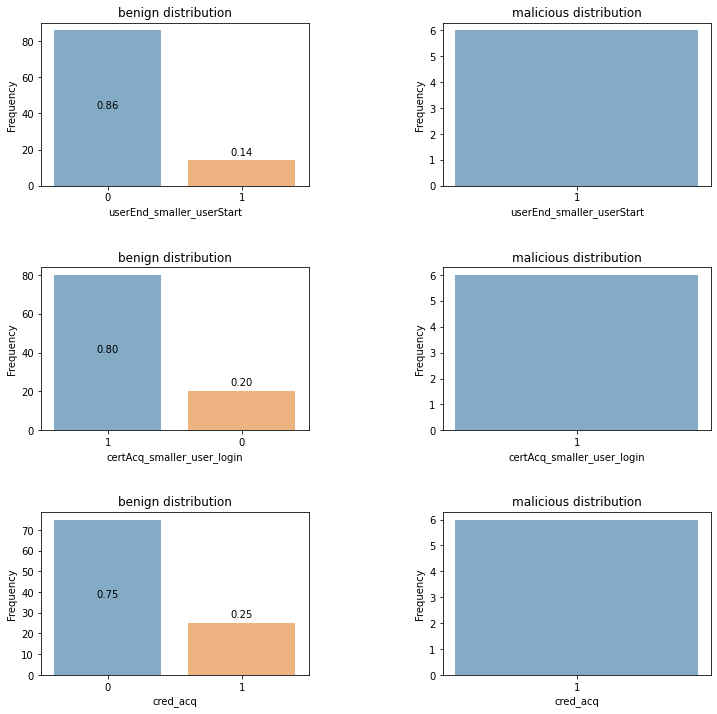

In [8]:
df['susp'] = 0
df.loc[df.index.isin(suspicious_process.index), 'susp'] = 1

df['userEnd_smaller_userStart'] = 0
df.loc[df['user_end'] < df['user_start'], 'userEnd_smaller_userStart'] = 1

df['certAcq_smaller_user_login'] = 0
df.loc[df['cred_acq'] <= df['user_login'], 'certAcq_smaller_user_login'] = 1


cols = ['userEnd_smaller_userStart', 'certAcq_smaller_user_login', 'cred_acq']
key = 'susp'
bengin = df.loc[df[key] == 0].reset_index()
malicious = df.loc[df[key] == 1].reset_index()

frames = [bengin, malicious]

ncol = 2
#nrow = math.ceil(len(relevant_cols)/ncol)
nrow = 3
fig, axes = plt.subplots(nrow, ncol,figsize=(12,12))
j = 0
for r in range(nrow):
    i = 0
    col = cols[j]
    for c in range(ncol):
        plot_df = frames[i]
        ax = sns.barplot(x= list(plot_df[col].value_counts().index.astype(str)), y = list(plot_df[col].value_counts()), ax=axes[r,c], alpha = 0.6)
        total = plot_df[col].value_counts().sum()
        if len(list(plot_df[col].value_counts())) > 1:
            for p in ax.patches:
                    height = p.get_height()
                    if height / total > 0.3:
                        location = height/2
                    else:
                        location = height + 3
                    ax.text(p.get_x() + p.get_width() / 2.,
                            location ,
                            '{:1.2f}'.format(height / total),
                            ha="center")
        axes[r,c].set_ylabel('Frequency')
        axes[r,c].set_xlabel(col)
        if i == 0:
            title = 'benign distribution'
        else:
            title = 'malicious distribution'
        axes[r,c].set_title(title)
        i+=1
    j+=1
    

plt.subplots_adjust(wspace=0.5,hspace = 0.5)

## Get ssh commandlines from hop_1


this hypothesis will search for ssh commandlines that contain i or s flags  
i flag of ssh - login using key   
s flag of ssh - login using a socket file  

the suspicious event will be marked with  "trigger3"  



In [9]:
#get all events related to monitoring execve - running process 
audit_cmd = audit_df.select(F.col("process.pid").alias("process_pid"),F.col("agent.hostname").alias("hostname"),F.col("process.args").alias("process_args"),\
                            F.col("file.path").alias("file_path"),F.col("user.name").alias("user_name"),F.col("@timestamp").alias("time")).filter(F.array_contains("tags","T1219_Remote_Access_Tools_7") )


#preprocessing the data because in default each field is an array
audit_cmd2 = audit_cmd.withColumn("process_pid", audit_cmd["process_pid"] 
                                .getItem(0)).withColumn("hostname", audit_cmd["hostname"]
                                .getItem(0)).withColumn("process_args", audit_cmd["process_args"]
                                 ).withColumn("file_path", audit_cmd["file_path"]       
                                .getItem(0)).withColumn("user_name", audit_cmd["user_name"]                                                                        
                                .getItem(0)).withColumn("time", audit_cmd["time"].getItem(0))

#search ssh commandlines using socket or keys instead of password-based credentials 
audit_cmd_key = audit_cmd2.filter(F.array_contains("process.args","-S") | F.array_contains("process.args","-i"))

audit_cmd_key=audit_cmd_key.withColumn("trigger3", F.lit(1))

In [10]:
audit_cmd_key_pd =audit_cmd_key.toPandas()
audit_cmd_key_pd.head()

,process_pid,hostname,process_args,file_path,user_name,time,trigger3
0,21135,centos7-more-rules,"[ssh, -S, /tmp/root@10.168.233.140:22, %h]",/usr/bin/ssh,root,2020-10-06 12:06:29.381,1


# Joins 

## Join hop - socket open and cmdline 
### By time and pid  - try to connect the hop to the target

In [11]:
#changing the names of the columns to not get ambigious column names after the join 
audit_cmd_key2 = audit_cmd_key.withColumnRenamed("time","time_cmd").withColumnRenamed("process_pid","process_pid_cmd").withColumnRenamed("hostname","hostname_potential_hop")
read_audit_exfil2 = read_audit_exfil.withColumnRenamed("process_pid","process_pid_socket").withColumnRenamed("hostname","hostname_potential_target")

#trying to find who is the target and who is the hop 
left_join = read_audit_exfil2.join(audit_cmd_key2,(audit_cmd_key2.hostname_potential_hop != read_audit_exfil2.hostname_potential_target),how='left')

#casting the time to sec 
time_diff = left_join.withColumn(
    "date_diff_start", 
    (F.col("time_cmd").cast("long") - F.col("socket_min_time").cast("long"))/60.
).withColumn(
    "date_diff_end", 
    (F.col("socket_max_time").cast("long") - F.col("time_cmd").cast("long"))/60.
)

#find cmdline that happend in a small delta of time from the open socket file 
cmd_socket_related = time_diff.filter((F.col("date_diff_start") >= 0 ) & \
                                      (F.col("date_diff_start") < 300) & (F.col("socket_min_time") == F.col("socket_max_time")) | 
                                      (F.col("date_diff_start") >= 0 ) & (F.col("date_diff_start") < 300) &
                                      ((F.col("socket_min_time") != F.col("socket_max_time")) & (F.col("date_diff_end") >= 0 ) & (F.col("date_diff_end") < 300)))


cmd_socket_related =cmd_socket_related.drop('date_diff_start','date_diff_end','window')
cmd_socket_related = cmd_socket_related.withColumn("socket_long_max_t", F.col("socket_max_time").cast("long")).withColumn("socket_long_min_t", F.col("socket_min_time").cast("long"))



In [12]:
cmd_socket_related_pd = cmd_socket_related.toPandas()
cmd_socket_related_pd.head()

,hostname_potential_target,process_pid_socket,socket_min_time,socket_max_time,trigger4,process_pid_cmd,hostname_potential_hop,process_args,file_path,user_name,time_cmd,trigger3,socket_long_max_t,socket_long_min_t
0,centos8-more-rules,1832,2020-10-06 07:22:22.245,2020-10-06 07:22:22.245,1,21135,centos7-more-rules,"[ssh, -S, /tmp/root@10.168.233.140:22, %h]",/usr/bin/ssh,root,2020-10-06 12:06:29.381,1,1601968942,1601968942
1,centos8-more-rules,2047,2020-10-06 07:39:35.204,2020-10-06 07:39:35.204,1,21135,centos7-more-rules,"[ssh, -S, /tmp/root@10.168.233.140:22, %h]",/usr/bin/ssh,root,2020-10-06 12:06:29.381,1,1601969975,1601969975
2,centos8-more-rules,3446,2020-10-06 12:05:23.418,2020-10-06 12:05:23.418,1,21135,centos7-more-rules,"[ssh, -S, /tmp/root@10.168.233.140:22, %h]",/usr/bin/ssh,root,2020-10-06 12:06:29.381,1,1601985923,1601985923
3,centos8-more-rules,2166,2020-10-06 07:46:18.167,2020-10-06 07:46:18.167,1,21135,centos7-more-rules,"[ssh, -S, /tmp/root@10.168.233.140:22, %h]",/usr/bin/ssh,root,2020-10-06 12:06:29.381,1,1601970378,1601970378


### Add ssh configuration change - the hop finding

In [13]:
#changing the names of the column's to not get ambigious column names after the join and casting the time to be long for delta calaulations
ssh_conf_change_clean = ssh_conf_change.withColumn("conf_long_min_t", F.col("conf_min_time").cast("long"))
ssh_conf_change_clean = ssh_conf_change_clean.withColumn("conf_long_max_t", F.col("conf_max_time").cast("long")).withColumnRenamed("process_pid","process_pid_conf")
ssh_conf_change_clean =ssh_conf_change_clean.withColumnRenamed("hostname","conf_hostname").withColumnRenamed("user_name","user_changed_conf").drop('window','hostname')


#finding the socket events in a small delta of time from the ssh configuration change (in a time diff of 12 hours due to fact that attacker can change the configuration a head to make it less noisy)
#the delta also considers the data loss and different delays that may happen between the event shipping 
joined_hop_info = cmd_socket_related.join(ssh_conf_change_clean,((ssh_conf_change_clean.conf_hostname == cmd_socket_related.hostname_potential_hop)& \
                                                                 (ssh_conf_change_clean.user_changed_conf == cmd_socket_related.user_name ) & \
                                                                 ((ssh_conf_change_clean.conf_long_min_t - cmd_socket_related.socket_long_min_t)/60 <=0) &\
                                                                 ( (cmd_socket_related.socket_long_max_t - ssh_conf_change_clean.conf_long_max_t)/60 >=0) & \
                                                                 ((cmd_socket_related.socket_long_max_t - ssh_conf_change_clean.conf_long_max_t)/60 <=44000 )),how='left')
joined_hop_info_clean = joined_hop_info.drop('conf_long_min_t','conf_long_max_t','conf_hostname')



In [14]:
joined_hop_info_clean_pd = joined_hop_info_clean.toPandas()
joined_hop_info_clean_pd.head()

,hostname_potential_target,process_pid_socket,socket_min_time,socket_max_time,trigger4,process_pid_cmd,hostname_potential_hop,process_args,file_path,user_name,time_cmd,trigger3,socket_long_max_t,socket_long_min_t,process_pid_conf,user_changed_conf,conf_min_time,conf_max_time,trigger1
0,centos8-more-rules,1832,2020-10-06 07:22:22.245,2020-10-06 07:22:22.245,1,21135,centos7-more-rules,"[ssh, -S, /tmp/root@10.168.233.140:22, %h]",/usr/bin/ssh,root,2020-10-06 12:06:29.381,1,1601968942,1601968942,NaN,None,NaT,NaT,NaN
1,centos8-more-rules,2047,2020-10-06 07:39:35.204,2020-10-06 07:39:35.204,1,21135,centos7-more-rules,"[ssh, -S, /tmp/root@10.168.233.140:22, %h]",/usr/bin/ssh,root,2020-10-06 12:06:29.381,1,1601969975,1601969975,NaN,None,NaT,NaT,NaN
2,centos8-more-rules,3446,2020-10-06 12:05:23.418,2020-10-06 12:05:23.418,1,21135,centos7-more-rules,"[ssh, -S, /tmp/root@10.168.233.140:22, %h]",/usr/bin/ssh,root,2020-10-06 12:06:29.381,1,1601985923,1601985923,NaN,None,NaT,NaT,NaN
3,centos8-more-rules,2166,2020-10-06 07:46:18.167,2020-10-06 07:46:18.167,1,21135,centos7-more-rules,"[ssh, -S, /tmp/root@10.168.233.140:22, %h]",/usr/bin/ssh,root,2020-10-06 12:06:29.381,1,1601970378,1601970378,NaN,None,NaT,NaT,NaN


## Join target 

In [15]:

process = spark.createDataFrame(suspicious_process)

#changing the names of the column's to not get ambigious column names after the join
joined_target_info_clean = process.withColumn("proc_long_min_t", F.col("very_min_time").cast("long")).withColumn("proc_long_max_t", F.col("very_max_time").cast("long"))
joined_target_info_clean = joined_target_info_clean.select('very_min_time','very_max_time','hostname','process_pid','proc_user_name','proc_long_min_t','proc_long_max_t','trigger2')


#finding the events on the target that were in a small delta of time from the hop events (with a larger scale of time since attacker changes the configuration in advance to make it less noisy)
#the delta also considers the data loss and diffrent delays that may happen between the event shipping 
overall_join = joined_target_info_clean.join(joined_hop_info_clean,(joined_target_info_clean.hostname == joined_hop_info_clean.hostname_potential_target)  & \
                                             (((joined_hop_info_clean.socket_long_min_t - joined_target_info_clean.proc_long_min_t)/60 >= -250) &\
                                              ((joined_hop_info_clean.socket_long_min_t - joined_target_info_clean.proc_long_min_t)/60 <= 100 ) &\
                                              ( (joined_target_info_clean.proc_long_max_t - joined_hop_info_clean.socket_long_max_t)/60  <= 7200 ) ),how = 'full')


overall_join = overall_join.withColumn("target_process_start_time", F.col("very_min_time")).withColumn("target_process_end_time", F.col("very_max_time"))

overall_join_clean = overall_join.drop('sock_long_min_t','sock_long_max_t','proc_long_min_t','proc_long_max_t','hostname').withColumnRenamed("process_pid_cmd","hop_suspicious_pid")



In [16]:
overall_join_clean_pd = overall_join_clean.toPandas()
overall_join_clean_pd.head()

,very_min_time,very_max_time,process_pid,proc_user_name,trigger2,hostname_potential_target,process_pid_socket,socket_min_time,socket_max_time,trigger4,hop_suspicious_pid,hostname_potential_hop,process_args,file_path,user_name,time_cmd,trigger3,socket_long_max_t,socket_long_min_t,process_pid_conf,user_changed_conf,conf_min_time,conf_max_time,trigger1,target_process_start_time,target_process_end_time
0,2020-10-06 05:24:52.152,2020-10-06 05:25:02.134,29892,emperor,1,None,NaN,NaT,NaT,NaN,NaN,None,None,None,None,NaT,NaN,NaN,NaN,NaN,None,NaT,NaT,NaN,2020-10-06 05:24:52.152,2020-10-06 05:25:02.134
1,2020-10-06 05:44:27.675,2020-10-06 05:44:28.212,29997,emperor,1,None,NaN,NaT,NaT,NaN,NaN,None,None,None,None,NaT,NaN,NaN,NaN,NaN,None,NaT,NaT,NaN,2020-10-06 05:44:27.675,2020-10-06 05:44:28.212
2,2020-10-06 05:25:26.569,2020-10-06 05:25:27.797,25778,emperor,1,None,NaN,NaT,NaT,NaN,NaN,None,None,None,None,NaT,NaN,NaN,NaN,NaN,None,NaT,NaT,NaN,2020-10-06 05:25:26.569,2020-10-06 05:25:27.797
3,2020-10-06 07:01:04.749,2020-10-06 07:01:05.021,19295,root,1,None,NaN,NaT,NaT,NaN,NaN,None,None,None,None,NaT,NaN,NaN,NaN,NaN,None,NaT,NaT,NaN,2020-10-06 07:01:04.749,2020-10-06 07:01:05.021
4,2020-10-06 12:05:26.456,2020-10-06 13:22:40.294,3446,root,1,centos8-more-rules,3446.0,2020-10-06 12:05:23.418,2020-10-06 12:05:23.418,1.0,21135.0,centos7-more-rules,"[ssh, -S, /tmp/root@10.168.233.140:22, %h]",/usr/bin/ssh,root,2020-10-06 12:06:29.381,1.0,1.601986e+09,1.601986e+09,NaN,None,NaT,NaT,NaN,2020-10-06 12:05:26.456,2020-10-06 13:22:40.294


# Combine host target by crypto_session events pid , ip ,port

In [17]:

#get all crypto_session events 
session_crypto_events = audit_df.select(F.col("auditd.message_type").alias("auditd_message_type"),\
                                        F.col("auditd.data.direction").alias("data_direction"),\
                                        F.col("process.pid").alias("process_pid"),\
                                        F.col("agent.hostname").alias("hostname"),\
                                        F.col("src_ip_addr").alias("source_ip"),\
                                        F.col("auditd.data.rport").alias("source_port"),\
                                        F.col("auditd.data.laddr").alias("dst_ip"),\
                                        F.col("auditd.data.lport").alias("dst_port"),\
                                        F.col("@timestamp").alias("time")).filter(F.array_contains("auditd_message_type","crypto_session"))


#preprocessing the data because in default each field is an array
session_crypto_events2 = session_crypto_events.withColumn("process_pid", session_crypto_events["process_pid"] 
                                .getItem(0)).withColumn("hostname", session_crypto_events["hostname"]
                                .getItem(0)).withColumn("source_ip", session_crypto_events["source_ip"]
                                 .getItem(0)).withColumn("source_port", session_crypto_events["source_port"]       
                                .getItem(0)).withColumn("dst_ip", session_crypto_events["dst_ip"]
                                .getItem(0)).withColumn("dst_port", session_crypto_events["dst_port"]
                                .getItem(0)).withColumn("data_direction", session_crypto_events["data_direction"]
                                .getItem(0)).withColumn("time", session_crypto_events["time"].getItem(0))


group_crypto_session = session_crypto_events2.groupby("process_pid","hostname","source_ip","source_port","dst_ip","dst_port").agg(F.min(F.col("time")).alias('min_time'),\
                                                                                                                                  F.max(F.col("time")).alias('max_time'),\
                                                                                                                                  F.collect_set(F.col("data_direction")))
#compartmentalizing events to start and end: combining start events and ending events into a session 
group_crypto_session_time = group_crypto_session.filter((F.col("max_time").cast("long") - F.col("min_time").cast("long"))/60 <180)




In [18]:
group_crypto_session_time_pd = group_crypto_session_time.toPandas()
group_crypto_session_time_pd.head()

,process_pid,hostname,source_ip,source_port,dst_ip,dst_port,min_time,max_time,collect_set(data_direction)
0,29997,localhost.localdomain,10.168.233.139,46036,10.169.232.214,22,2020-10-06 05:44:14.259,2020-10-06 05:44:14.260,"[from-server, from-client]"
1,18868,centos7-more-rules,10.61.40.27,56215,10.168.233.139,22,2020-10-06 05:41:52.349,2020-10-06 05:41:52.350,"[from-server, from-client]"
2,29892,localhost.localdomain,10.168.233.139,46028,10.169.232.214,22,2020-10-06 05:24:43.980,2020-10-06 05:24:43.981,"[from-server, from-client]"
3,21083,centos7-more-rules,10.21.244.187,58162,10.168.233.139,22,2020-10-06 12:05:08.202,2020-10-06 12:05:08.203,"[from-server, from-client]"
4,18790,centos7-more-rules,10.61.40.27,56105,10.168.233.139,22,2020-10-06 05:31:08.269,2020-10-06 05:31:08.269,"[from-server, from-client]"


###  Get all data bulked in process start and end time (by event)

In [19]:
session_crypto_events = audit_df.select(F.col("process.pid").alias("process_pid"),F.col("agent.hostname").alias("hostname"),F.col("@timestamp").alias("time"))

#getting the process information related to the crypto session 
grouped_process = session_crypto_events.groupby("process_pid","hostname",).agg(F.min(F.col("time")).alias('min_time'),F.max(F.col("time")).alias('max_time'))

#preprocessing the data because in default each field is an array
ordered_grouped_process = grouped_process.withColumn("process_pid", grouped_process["process_pid"] 
                                .getItem(0)).withColumn("hostname", grouped_process["hostname"]
                                .getItem(0)).withColumn("max_time", grouped_process["max_time"]
                                 .getItem(0)).withColumn("min_time", grouped_process["min_time"].getItem(0))

#changing the column's names to not get ambigious column names after the join
ordered_grouped_process_names_change = ordered_grouped_process.withColumnRenamed("process_pid", "a_process_pid").withColumnRenamed("hostname", "a_hostname")
ordered_grouped_process_names_change=ordered_grouped_process_names_change.withColumnRenamed("max_time", "a_max_time").withColumnRenamed("min_time", "a_min_time")


In [20]:
ordered_grouped_process_names_change_pd = ordered_grouped_process_names_change.toPandas()
ordered_grouped_process_names_change_pd.head()

,a_process_pid,a_hostname,a_min_time,a_max_time
0,1.0,ubuntu18-clear,2020-10-06 02:19:06.820,2020-10-06 23:21:23.930
1,1531.0,ubuntu18rsc,2020-10-06 21:45:01.334,2020-10-06 21:45:01.342
2,1746.0,ubuntu18rsc,2020-10-06 22:12:01.737,2020-10-06 22:12:01.745
3,2244.0,ubuntu18rsc,2020-10-06 23:18:01.700,2020-10-06 23:18:01.712
4,19666.0,centos7-more-rules,2020-10-06 07:30:39.108,2020-10-06 07:30:39.110


### Add start and end time to process from crypto session 

In [21]:
#-------pay attention-----------
#the session time (both start and end) are for the total sessions (valid session including the malicous hijack inside)
sessions_and_time = group_crypto_session_time.join(ordered_grouped_process_names_change,(group_crypto_session_time.hostname == ordered_grouped_process_names_change.a_hostname ) &\
                                                   (group_crypto_session_time.process_pid == ordered_grouped_process_names_change.a_process_pid) )


sessions_and_time_clean = sessions_and_time.drop("process_pid","a_hostname","min_time","max_time").withColumnRenamed("a_max_time","session_end_time").withColumnRenamed("a_min_time","session_start_time")
sessions_and_time_clean=sessions_and_time_clean.withColumnRenamed("collect_set(data_direction)","data_direction")

sessions_and_time_clean = sessions_and_time_clean.withColumn("trigger5", F.lit(1))

## Add network information to final results

In [23]:
#joining all data in a logic time range and difference from each event
final_results_join_process = overall_join_clean.join(sessions_and_time_clean,((overall_join_clean.hostname_potential_target == sessions_and_time_clean.hostname) & \
                                                                              (overall_join_clean.process_pid == sessions_and_time_clean.a_process_pid) &\
                                                                              (overall_join_clean.target_process_start_time >= sessions_and_time_clean.session_start_time) & \
                                                                              (overall_join_clean.target_process_end_time <= sessions_and_time_clean.session_end_time)) |\
                                                     ( (overall_join_clean.hostname_potential_hop == sessions_and_time_clean.hostname) &\
                                                      (overall_join_clean.hop_suspicious_pid == sessions_and_time_clean.a_process_pid) &\
                                                      (overall_join_clean.socket_min_time >= sessions_and_time_clean.session_start_time) &\
                                                      (overall_join_clean.socket_max_time <= sessions_and_time_clean.session_end_time)), how = "left" )
#900 sec = 5 min
final_results_join = final_results_join_process.filter( ~ (F.col("hostname_potential_target").isNull()  & F.col("hostname_potential_hop").isNull()))


final_results_join = final_results_join.drop("a_process_pid","hostname")

# Final 

In [24]:
final = final_results_join.toPandas()
final = final.fillna(0)

final['score'] = final['trigger1']+final['trigger2']+final['trigger3']+final['trigger4']+final['trigger5']
final


,very_min_time,very_max_time,process_pid,proc_user_name,trigger2,hostname_potential_target,process_pid_socket,socket_min_time,socket_max_time,trigger4,hop_suspicious_pid,hostname_potential_hop,process_args,file_path,user_name,time_cmd,trigger3,socket_long_max_t,socket_long_min_t,process_pid_conf,user_changed_conf,conf_min_time,conf_max_time,trigger1,target_process_start_time,target_process_end_time,source_ip,source_port,dst_ip,dst_port,data_direction,session_start_time,session_end_time,trigger5,score
0,2020-10-06 07:46:21.166,2020-10-06 07:46:21.210,2166,root,1,centos8-more-rules,1832,2020-10-06 07:22:22.245,2020-10-06 07:22:22.245,1,21135,centos7-more-rules,"[ssh, -S, /tmp/root@10.168.233.140:22, %h]",/usr/bin/ssh,root,2020-10-06 12:06:29.381,1,1601968942,1601968942,0.0,0,0,0,0.0,2020-10-06 07:46:21.166,2020-10-06 07:46:21.210,10.61.40.27,57166,10.168.233.140,22,"[from-server, from-client]",2020-10-06 07:46:18.167,2020-10-06 10:04:44.157,1,4.0
1,2020-10-06 07:46:21.166,2020-10-06 07:46:21.210,2166,root,1,centos8-more-rules,2047,2020-10-06 07:39:35.204,2020-10-06 07:39:35.204,1,21135,centos7-more-rules,"[ssh, -S, /tmp/root@10.168.233.140:22, %h]",/usr/bin/ssh,root,2020-10-06 12:06:29.381,1,1601969975,1601969975,0.0,0,0,0,0.0,2020-10-06 07:46:21.166,2020-10-06 07:46:21.210,10.61.40.27,57166,10.168.233.140,22,"[from-server, from-client]",2020-10-06 07:46:18.167,2020-10-06 10:04:44.157,1,4.0
2,2020-10-06 12:05:26.456,2020-10-06 13:22:40.294,3446,root,1,centos8-more-rules,3446,2020-10-06 12:05:23.418,2020-10-06 12:05:23.418,1,21135,centos7-more-rules,"[ssh, -S, /tmp/root@10.168.233.140:22, %h]",/usr/bin/ssh,root,2020-10-06 12:06:29.381,1,1601985923,1601985923,0.0,0,0,0,0.0,2020-10-06 12:05:26.456,2020-10-06 13:22:40.294,10.168.233.139,58806,10.168.233.140,22,"[from-server, from-client]",2020-10-06 12:05:23.418,2020-10-06 13:22:40.294,1,4.0
3,2020-10-06 07:46:21.166,2020-10-06 07:46:21.210,2166,root,1,centos8-more-rules,2166,2020-10-06 07:46:18.167,2020-10-06 07:46:18.167,1,21135,centos7-more-rules,"[ssh, -S, /tmp/root@10.168.233.140:22, %h]",/usr/bin/ssh,root,2020-10-06 12:06:29.381,1,1601970378,1601970378,0.0,0,0,0,0.0,2020-10-06 07:46:21.166,2020-10-06 07:46:21.210,10.61.40.27,57166,10.168.233.140,22,"[from-server, from-client]",2020-10-06 07:46:18.167,2020-10-06 10:04:44.157,1,4.0



fields explanations :  

target_process_start_time - what was the start time of the process that attacked the target (the ssh connection process)  
target_process_end_time - what was the end time of the process that attacked the target (the ssh connection process)  
process_pid - what was the process id of the process that ran on the target machine which preformed the suspicious action  
proc_user_name - who is the user that ran the suspicious process on the target  
trigger2 - flag that determines if the specific time, process, and endpoint are suspicious by hypothesis 2 (anomaly in authentication process)  
process_pid_conf - the process id of the process that changes the ssh configuration on the hop endpoint  
user_changed_conf  - the user that started the process that changes the ssh configuration on the hop endpoint  
conf_min_time - the start time of the process that changes the ssh configuration on the hop endpoint  
conf_max_time - the end time of the process that changes the ssh configuration on the hop endpoint  
trigger1 - flag that determines if the specific time, process, and endpoint are suspicious by hypothesis 1(ssh configuration changed)  
hostname_potential_target- the endpoint that is suspected as the target   
socket_min_time - the start time of the socket creation on the hop endpoint   
socket_max_time - the end time of the socket creation on the hop endpoint (not the end time of the socket itself)  
trigger4 - flag that determines if the specific time, process, and endpoint are suspicious by hypothesis 4 (ssh socket created)  
hop_suspicious_pid - process id of the process suspected as malicious on the hop endpoint  
hostname_potential_hop - host name of the suspicious as hop endpoint  
process_args - the process arguments of the process suspected as malicious on the hop endpoint  
file_path - the path of the binary running the suspicious and potentially malicious process on the hop endpoint   
user_name - the user that ran the suspicious potentially malicious process on the hop endpoint   
time_cmd - the start time of the process with the suspicious potentially malicious process on the hop endpoint   
trigger3 - flag that determines if the specific time, process, and endpoint are suspicious by hypothesis 3 (ssh connection wiith key or socket in cmdline)  
source_ip - the source ip of the communication between the hop and target endpoints   
source_port - the source port of the communication between the hop and target endpoints  
dst_ip - the destination ip of the communication between the hop and target endpoints  
dst_port -  the destination port of the communication between the hop and target endpoints  
data_direction - the data direction between the hop and target machine   
session_start_time - the start time of the suspicious potentially malicious session between the hop and target  
session_end_time - the end time of the suspicious potentially malicious session between the hop and target  
trigger5 - flag that determines if the specific time, process, and endpoint are suspicious by hypothesis 5 (network connection in the time of other events)  
score - how many hypotheses are found within this connection as suspicious? - 5 being the highest - 1 being the lowest   
